In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [22]:
bbca = pd.read_excel("./Data/DataCleaned/Data_BBCA_Cleaned.xlsx")
bbri = pd.read_excel("./Data/DataCleaned/Data_BBRI_Cleaned.xlsx")
bmri = pd.read_excel("./Data/DataCleaned/Data_BMRI_Cleaned.xlsx")
bbni = pd.read_excel("./Data/DataCleaned/Data_BBNI_Cleaned.xlsx")


In [23]:
np.random.seed(42)
missing_idx = np.random.choice(bbca.index, size=int(0.2 * len(bbca)), replace=False)

true_close = bbca.loc[missing_idx, 'Close'].values
bbca_missing = bbca.copy()
bbca_missing.loc[missing_idx, 'Close'] = np.nan

In [24]:
train_bbca = bbca_missing.dropna(subset=['Close'])
X_bbca = train_bbca[['Open', 'High', 'Low']]
y_bbca = train_bbca['Close']

X_bbca_pred = bbca.loc[missing_idx, ['Open', 'High', 'Low']]

model_bbca = RandomForestRegressor(n_estimators=100, random_state=42)
model_bbca.fit(X_bbca, y_bbca)

pred_bbca_only = model_bbca.predict(X_bbca_pred)


In [25]:
def train_model(df_features, df_target, target_dates):
    X = df_features.loc[df_target.index, ['Open', 'High', 'Low']]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, df_target)
    X_pred = df_features.loc[target_dates, ['Open', 'High', 'Low']]
    return model.predict(X_pred)


In [26]:
df_bbca_train = bbca_missing.dropna(subset=['Close'])
target_y = df_bbca_train['Close']

pred_bbca_rf = train_model(bbca, target_y, missing_idx)
pred_bbri_rf = train_model(bbri, target_y, missing_idx)
pred_bmri_rf = train_model(bmri, target_y, missing_idx)
pred_bbni_rf = train_model(bbni, target_y, missing_idx)

X_stack = pd.DataFrame({
    'BBCA': pred_bbca_rf,
    'BBRI': pred_bbri_rf,
    'BMRI': pred_bmri_rf,
    'BBNI': pred_bbni_rf
})

In [27]:
meta_model = LinearRegression()
meta_model.fit(X_stack, true_close)

pred_stack_all = meta_model.predict(X_stack)



In [28]:
eval_data = {
    "RF_BBCA_Only": {
        "MAE": mean_absolute_error(true_close, pred_bbca_only),
        "RMSE": np.sqrt(mean_squared_error(true_close, pred_bbca_only)),
        "R2": r2_score(true_close, pred_bbca_only)
    },
    "Stacking_All": {
        "MAE": mean_absolute_error(true_close, pred_stack_all),
        "RMSE": np.sqrt(mean_squared_error(true_close, pred_stack_all)),
        "R2": r2_score(true_close, pred_stack_all)
    }
}

for model, metrics in eval_data.items():
    print(f"Model: {model}")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    print()



Model: RF_BBCA_Only
  MAE: 22.5297
  RMSE: 39.2415
  R2: 0.9998

Model: Stacking_All
  MAE: 22.5924
  RMSE: 39.2176
  R2: 0.9998



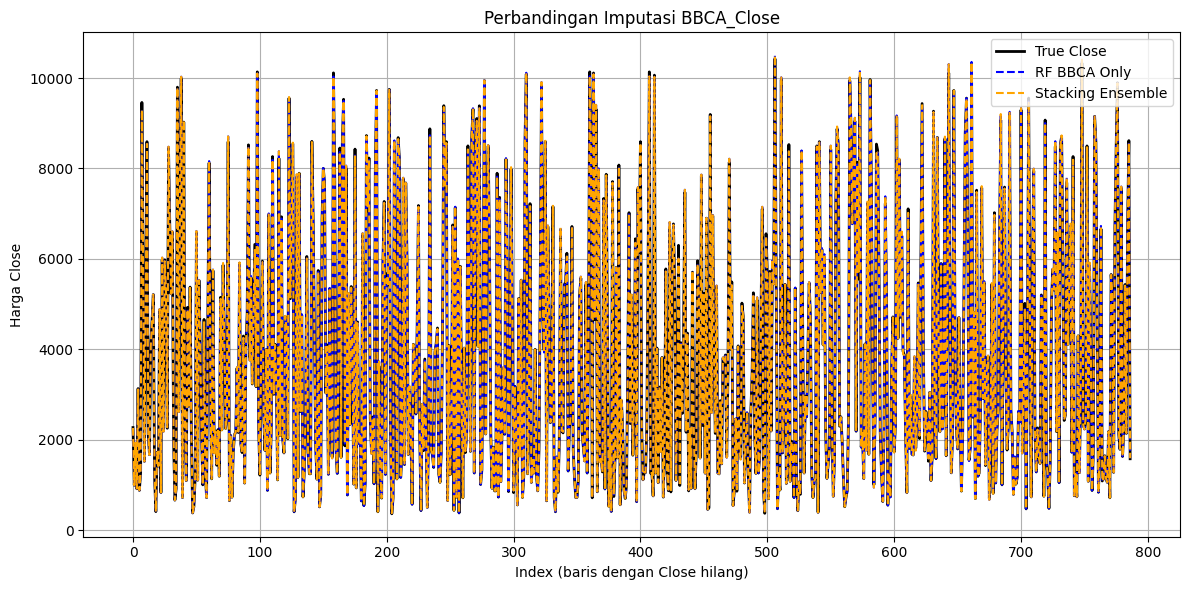

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(true_close, label='True Close', color='black', linewidth=2)
plt.plot(pred_bbca_only, label='RF BBCA Only', linestyle='--', color='blue')
plt.plot(pred_stack_all, label='Stacking Ensemble', linestyle='--', color='orange')

plt.title('Perbandingan Imputasi BBCA_Close')
plt.xlabel('Index (baris dengan Close hilang)')
plt.ylabel('Harga Close')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
